# Imports

In [41]:
## LOAD LIBRARIES
import pandas as pd
import numpy as np

# Import all we need from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder

# Import XGBoost
import xgboost as xgb

#Import optuna
import optuna

# Import visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [26]:
df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Machine_Learning/Supervised_Learning/Data/Clean_Data_Titanic.csv')
print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  adult_male  \
0         0       3    male  22.0      1      0   7.2500        S        True   
1         1       1  female  38.0      1      0  71.2833        C       False   
2         1       3  female  26.0      0      0   7.9250        S       False   
3         1       1  female  35.0      1      0  53.1000        S       False   
4         0       3    male  35.0      0      0   8.0500        S        True   

   alone  
0  False  
1  False  
2   True  
3  False  
4   True  


# Label Encoding

In [27]:
## CONVERT CATEGORICAL LABELS TO NUMERIC LABELS

le = LabelEncoder()
df['survived'] = le.fit_transform(df['survived'])

# OneHot Encoding of Categorical Variables

In [28]:
label_col = 'survived'

labels = df[label_col]
df.drop([label_col], inplace=True, axis=1)
df = pd.get_dummies(df, dtype='int', columns = ['pclass', 'sex', 'embarked', 'alone', 'adult_male'])
df[label_col] = labels

# Create Train and Test Sets

### For No Cross Validation

In [49]:
# X will contain all variables except the labels (the labels are the first column 'survived')
X = df.iloc[:,:-1]
# y will contain the labels (the labels are the first column 'survived')
y = df['survived']
               
# split the data vectors randomly into 80% train and 20% test
# X_train contains the quantitative variables for the training set
# X_test contains the quantitative variables for the testing set
# y_train contains the labels for training set
# y_test contains the lables for the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Fit Initial Model

In [31]:
# documentation for parameters
# https://xgboost.readthedocs.io/en/latest/parameter.html

xgb_Classifier = xgb.XGBClassifier()
xgb_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = xgb_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[92 21]
 [20 46]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       113
           1       0.69      0.70      0.69        66

    accuracy                           0.77       179
   macro avg       0.75      0.76      0.75       179
weighted avg       0.77      0.77      0.77       179



# Tune Model - W/O Cross Validation

In [38]:
def objective(trial, X_train, y_train, X_test, y_test):

    param = {
        "verbosity": 0,
        # "scale_pos_weight": trial.suggest_float('scale_pos_weight', 0, 3),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-10, 1e10, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0, 0.1),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 15)
        param["eta"] = trial.suggest_float("eta", 1e-8, 2.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 120, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Fit the model
    optuna_model = xgb.XGBClassifier(**param)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    score_metric = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    return score_metric

In [39]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 15:59:33,348] A new study created in memory with name: no-name-67ef7c11-d4c9-4225-b927-7d4ced0a6560


In [40]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

[I 2024-03-23 15:59:35,305] Trial 0 finished with value: 0.7652419544674984 and parameters: {'lambda': 4.676933510605141e-05, 'alpha': 2.0104836606743393e-08, 'min_child_weight': 2208.7858911615185, 'subsample': 0.44406326432128557, 'colsample_bytree': 0.5514769359742049, 'learning_rate': 0.028255313595333488, 'num_boost_round': 351, 'booster': 'gblinear'}. Best is trial 0 with value: 0.7652419544674984.


[I 2024-03-23 15:59:37,155] Trial 1 finished with value: 0.7839903459372486 and parameters: {'lambda': 4.365548581802525e-08, 'alpha': 0.16477452338016746, 'min_child_weight': 0.0006995552967233929, 'subsample': 0.315036688957718, 'colsample_bytree': 0.7253955890782915, 'learning_rate': 0.08848312733952397, 'num_boost_round': 548, 'booster': 'dart', 'max_depth': 9, 'eta': 7.143832187290693e-08, 'gamma': 0.0019535191073042674, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0010706597775632708, 'skip_drop': 2.6398022946062387e-07}. Best is trial 1 with value: 0.7839903459372486.
[I 2024-03-23 15:59:37,272] Trial 2 finished with value: 0.386986301369863 and parameters: {'lambda': 6.719243605602889e-06, 'alpha': 2.13398148844646e-07, 'min_child_weight': 410868418.2636986, 'subsample': 0.5950874935152184, 'colsample_bytree': 0.35325997344083726, 'learning_rate': 0.09439293900093121, 'num_boost_round': 411, 'booster': 'gbtree', 'max_depth': 3

Best Trial:  FrozenTrial(number=41, state=1, values=[0.8426567279631518], datetime_start=datetime.datetime(2024, 3, 23, 16, 0, 17, 947439), datetime_complete=datetime.datetime(2024, 3, 23, 16, 0, 18, 372168), params={'lambda': 0.0018171351141302598, 'alpha': 7.211818538566125e-05, 'min_child_weight': 2.0889061438436237e-08, 'subsample': 0.8450103400258043, 'colsample_bytree': 0.3338170260730394, 'learning_rate': 0.010505338786618974, 'num_boost_round': 688, 'booster': 'gbtree', 'max_depth': 13, 'eta': 0.004394154724776865, 'gamma': 6.981969410911996e-07, 'grow_policy': 'depthwise'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'min_child_weight': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'colsample_bytree': FloatDistribut

### Cross Validate Tuned Model

In [43]:
cv_model = xgb.XGBClassifier(**best_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\casey\anaconda3\

Cross Validation Scores:  [0.82924446 0.82059674 0.81389253 0.82167622 0.85837766]
Average CV Score:  0.8287575225210009
Number of CV Scores used in Average:  5


# Tune Model With Cross Validation

In [44]:
def objective(trial, X_train, y_train):

    param = {
        "verbosity": 0,
        # "scale_pos_weight": trial.suggest_float('scale_pos_weight', 0, 3),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-10, 1e10, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0, 0.1),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 15)
        param["eta"] = trial.suggest_float("eta", 1e-8, 2.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 120, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Fit the model with cv
    cv_model = xgb.XGBClassifier(**best_params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

    # Evaluate predictions
    return scores.mean()

In [45]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 16:05:00,643] A new study created in memory with name: no-name-6c12b728-ea4e-4388-bf34-ef2e01d561d5


In [46]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\casey\anaconda3\

Best Trial:  FrozenTrial(number=0, state=1, values=[0.8287575225210009], datetime_start=datetime.datetime(2024, 3, 23, 16, 5, 8, 750399), datetime_complete=datetime.datetime(2024, 3, 23, 16, 5, 10, 423621), params={'lambda': 0.00023298625582264198, 'alpha': 5.4192612155517396e-08, 'min_child_weight': 4.2195126942482295, 'subsample': 0.2753210585813813, 'colsample_bytree': 0.9906769560507751, 'learning_rate': 0.0821737136858999, 'num_boost_round': 957, 'booster': 'dart', 'max_depth': 5, 'eta': 0.00891104632087745, 'gamma': 1.1827950843345667, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.0399039341011684e-07, 'skip_drop': 0.004597490659870872}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'min_child_weight': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=

### Test CV Model with Test Set

In [47]:
xgb_Classifier = xgb.XGBClassifier(**best_params)
xgb_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = xgb_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[[100  13]
 [ 22  44]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       113
           1       0.77      0.67      0.72        66

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



# Confusion Matrix

[[100  13]
 [ 22  44]]


[Text(0, 0.5, '0:'), Text(0, 1.5, '1:')]

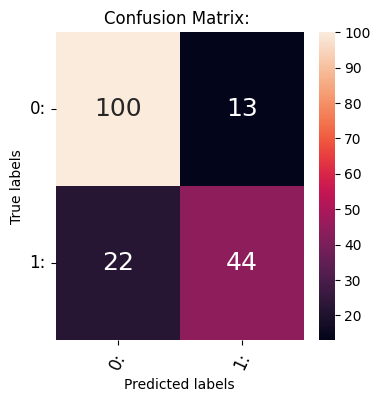

In [48]:
cm=confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)

# ---------------------------------------------------------------------------------------------------------------------------- #
## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: ')
ax.xaxis.set_ticklabels(["0:","1:"],rotation=65, fontsize = 12)

ax.yaxis.set_ticklabels(["0:","1:"],rotation=0, fontsize = 12)